In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os
from pyshred import DataManager, SHRED, SHREDEngine, MLP, PI_SHRED, LSTM, LSTM_PI, PI_SHRED_V2, MLP_TRUNK
from torch.utils.data import DataLoader, random_split
import Master_utilz as utilz
from scipy.fft import fft, ifft, fftshift, fftfreq
from scipy.integrate import solve_ivp
from torch.autograd import grad

plt.rcParams.update({
    "font.family": "serif",
    # "font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm",       # Computer Modern for math
    "axes.unicode_minus": False,    # So minus sign appears correctly
})

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2.5e-05
20418
Finished RK4 with 20418 iterations final time = 0.5104500000000001


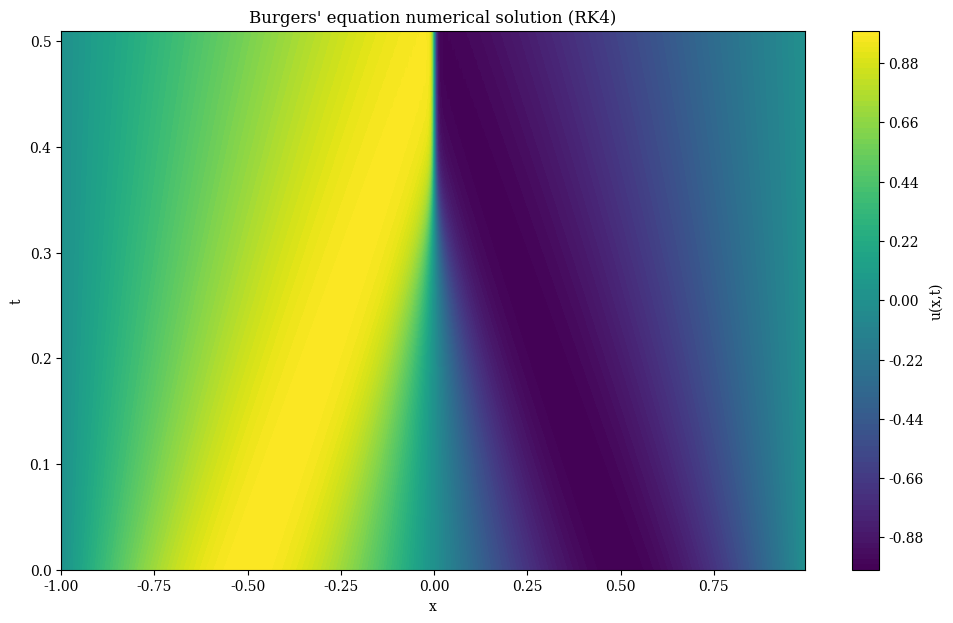

In [83]:
#Creating data by solving the burgers equation in 1D
def init_KS(x,t=0):
    u = (1+np.sin(x/10))
    return u

def Fourier_n(u, Omega,n):
    u_hat = (1j*Omega)**n*fft(u)
    u_hat = ifft(u_hat)
    return u_hat

N = 400
L = 2
x = np.linspace(-L/2, L/2, N, endpoint=False)
nu = 0.01/np.pi
n = fftfreq(N)*N
scale = 2*np.pi/L
Omega = scale*n
u0 = -np.sin(np.pi*x)

def burgers(u, Omega,nu):
    dudt = -0.5*Fourier_n(u*u, Omega, 1)+nu*Fourier_n(u, Omega, 2)
    return np.real(dudt)

def runge_kutta(u0,dudt,dt,iters, Omega,nu):
    t_all = np.zeros(iters)
    u_sol_all = np.zeros((iters,u0.size))
    u_sol = u0.copy()
    for i in range(iters):
        k1 = dudt(u_sol,Omega,nu)
        k2 = dudt(u_sol + 0.5*dt*k1,Omega,nu)
        k3 = dudt(u_sol + 0.5*dt*k2,Omega,nu)
        k4 = dudt(u_sol + dt*k3,Omega,nu)
        u_sol = u_sol + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)
        u_sol_all[i,:] = u_sol
        t_all[i] = dt*i
    print(f"Finished RK4 with {iters} iterations final time = {dt*iters}")
    return u_sol_all,t_all

delta_t = 2*np.abs(2 / ((N) ** 2))
print(delta_t)
t_end =  1.6037/np.pi

iters = int(t_end/delta_t)
print(iters)
img_test = max(u0)*2/N
u_sol,t = runge_kutta(u0,burgers,delta_t,iters, Omega,nu)

t_skips = iters//50
# t_skips = 210
x_skips = 1
t = t[::t_skips]
u_sol = u_sol[::t_skips,::x_skips]
x = x[::x_skips]
delta_t_synth = delta_t*t_skips

fig,ax = plt.subplots(figsize=(12,7))   
ax.contourf(x,t,u_sol, 100, cmap="viridis")
ax.set_title("Burgers' equation numerical solution (solve_ivp)")
ax.set_title("Burgers' equation numerical solution (RK4)")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_xlabel("x")
ax.set_ylabel("t")
fig.colorbar(ax.collections[0], ax=ax, label='u(x,t)')
plt.show()

In [84]:
print(u_sol.shape)
lags = 15

print((u_sol.shape[0]-lags)*u_sol.shape[1])

(51, 400)
14400


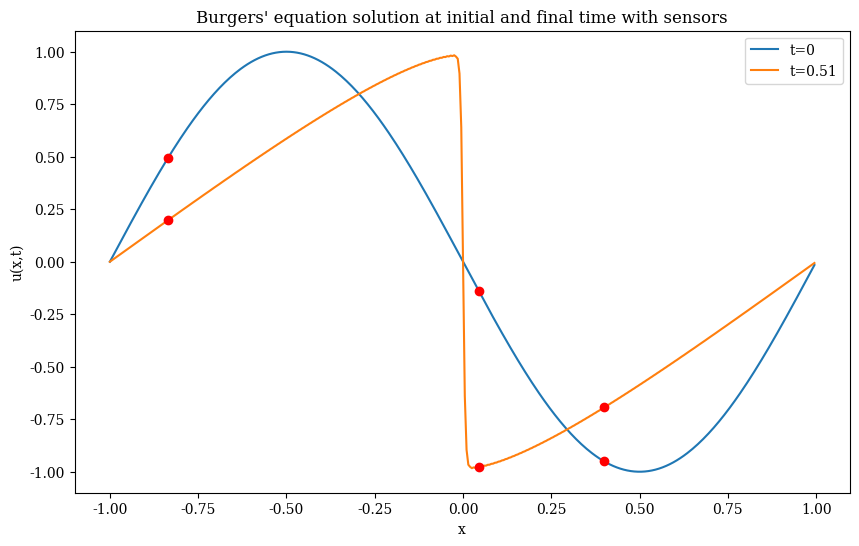

In [86]:
lags = 30
nr_sensors = 3
np.random.seed(42)
sensors = sensors = np.random.choice(np.arange(0,u_sol.shape[1]),nr_sensors,replace = False)
test_frames = 5
# X_train,y_train, scaler = utilz.data_prepare([u_sol],lags =lags, sensors=sensors)
X_train,y_train = utilz.trajectory_gen([u_sol[:-test_frames]],lags =lags, sensors=sensors)
X_test, y_test = utilz.trajectory_gen([u_sol[(-test_frames-lags):]],lags =lags, sensors=sensors)
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(x,u_sol[0,:], label='t=0')
for sensor in sensors:
    ax.plot(x[sensor], u_sol[0,sensor],"o", color='red')
ax.plot(x,u_sol[-1,:], label=f't={t[-1]:.2f}')
for sensor in sensors:
    ax.plot(x[sensor], u_sol[-1,sensor],"o", color='red')
ax.set_title("Burgers' equation solution at initial and final time with sensors")
ax.set_xlabel("x")
ax.set_ylabel("u(x,t)")
ax.legend()
plt.show()

# Decided to make the data in a stacking manner because I cannot make the other thing work...

In [87]:
class SHREDdata_PI(torch.utils.data.Dataset):
    """
    PyTorch Dataset for time series sensor data and corresponding full-state measurements.

    Parameters
    ----------
    DATA: dictionary containg X and y
    
    X : torch.Tensor
        Input sensor sequences of shape (batch_size, lags, num_sensors).
    Y : torch.Tensor
        Target full-state measurements of shape (batch_size, state_dim).

    Attributes
    ----------
    X : torch.Tensor
        Sensor measurement sequences.
    Y : torch.Tensor
        Full-state target measurements.
    len : int
        Number of samples in the dataset.
    """

    def __init__(self, DATA):
        """
        Initialize the TimeSeriesDataset.

        Parameters
        ----------
        X : torch.Tensor
            Input sensor sequences of shape (batch_size, lags, num_sensors).
        Y : torch.Tensor
            Target full-state measurements of shape (batch_size, state_dim).
        """
        self.X = DATA['X']
        self.coords = DATA['coords']
        self.Y = DATA['y']
        self.len = self.X.shape[0]
        
    def __getitem__(self, index):
        """
        Get a single sample from the dataset.

        Parameters
        ----------
        index : int
            Index of the sample to retrieve.

        Returns
        -------
        tuple
            (sensor_sequence, target_state) pair.
        """
        return self.X[index], self.coords[index], self.Y[index]

    def __len__(self):
        """
        Get the number of samples in the dataset.

        Returns
        -------
        int
            Number of samples.
        """
        return self.len
     
    def split_data(self, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42,sequential_split=False):
        if sequential_split:
            total_len = len(self)
            train_end = int(total_len * train_ratio)
            val_end = train_end + int(total_len * val_ratio)

            train_data = {
                'X': self.X[:train_end],
                'y': self.Y[:train_end],
                "coords" : self.coords
            }
            val_data = {
                'X': self.X[train_end:val_end],
                'y': self.Y[train_end:val_end],
                "coords" : self.coords
            }
            test_data = {
                'X': self.X[val_end:],
                'y': self.Y[val_end:],
                "coords" : self.coords
            }
            train_dataset = SHREDdata_PI(train_data)
            val_dataset = SHREDdata_PI(val_data)
            test_dataset = SHREDdata_PI(test_data)

        else:
            generator = torch.Generator().manual_seed(seed)
            train, val, test = torch.utils.data.random_split(self, [train_ratio, val_ratio, test_ratio], generator=generator)

            train_data = {
                'X':self.X[train.indices],
                'y':self.Y[train.indices],
                "coords" : self.coords
            }
            val_data = {
                'X':self.X[val.indices],
                'y':self.Y[val.indices],
                "coords" : self.coords
            }
            test_data = {
                'X':self.X[test.indices],
                'y':self.Y[test.indices],
                "coords" : self.coords
            }
            train_dataset = SHREDdata_PI(train_data)
            val_dataset = SHREDdata_PI(val_data)
            test_dataset = SHREDdata_PI(test_data)

        return train_dataset,val_dataset,test_dataset
    
    def move_to_device(self, device, model_dtype = torch.float32):
        self.X = torch.tensor(self.X, device=device, dtype=model_dtype)
        self.coords = torch.tensor(self.coords, device=device, dtype=model_dtype)
        self.Y = torch.tensor(self.Y, device=device, dtype=model_dtype)
        return self

In [88]:
def stack_data(X,y,coords):
    Nt = X.shape[0]
    Nxy = coords.shape[0]
    dim = Nt*Nxy
    X_stacked = np.zeros((dim, X.shape[1], X.shape[2]))
    coords_stacked = np.zeros((dim, coords.shape[1]))
    y_stacked = y.flatten()[:,None]
    for i in range(Nt):
        X_stacked[i*Nxy:(i+1)*Nxy,:,:] = X[i,:,:].copy()
        coords_stacked[i*Nxy:(i+1)*Nxy,:] = coords.copy()
    dims = [Nt,Nxy]
    return X_stacked, y_stacked, coords_stacked,dims

def unstack_data(X,y,coords, dims):
    Nt, Nxy = dims
    X_unstacked = X.copy()
    y_unstacked = y.copy()
    coords_unstacked = coords.copy()
    X_unstacked = X_unstacked.reshape(Nt,Nxy,X_unstacked.shape[1], X_unstacked.shape[2])
    X_unstacked = X_unstacked[:,0,:,:]
    coords_unstacked = coords_unstacked[0:Nxy,:]
    y_unstacked = y_unstacked.reshape(Nt,Nxy)
    return X_unstacked, y_unstacked, coords_unstacked

In [89]:
print(X_train.shape, y_train.shape, x[:,None].shape)
X_stacked, y_stacked, coords_stacked, dims = stack_data(X_train,y_train,x[:,None])
print(X_stacked.shape, y_stacked.shape, coords_stacked.shape)
X_unstacked, y_unstacked, coords_unstacked = unstack_data(X_stacked,y_stacked,coords_stacked, dims)
print(X_unstacked.shape, y_unstacked.shape, coords_unstacked.shape)
print(dims[0],dims[1])

(16, 30, 3) (16, 400) (400, 1)
(6400, 30, 3) (6400, 1) (6400, 1)
(16, 30, 3) (16, 400) (400, 1)
16 400


In [145]:
X_stacked, y_stacked, coords_stacked, dims = stack_data(X_train,y_train,x[:,None])
train_data_stacked = {
    'X':X_stacked,
    "coords" : coords_stacked,
    'y':y_stacked,
}

X_test_stacked, y_test_stacked, coords_test_stacked, dims_test = stack_data(X_test,y_test,x[:,None])
test_data_stacked = {
    'X':X_test_stacked,
    "coords" : coords_test_stacked,
    'y':y_test_stacked,
}

Nt = dims[0]
Nxy = dims[1]

nr_timesteps_in_batch = 1000
model_dtype = torch.float32
stacked_dataset = SHREDdata_PI(train_data_stacked)
stacked_test_dataset = SHREDdata_PI(test_data_stacked)
stacked_test_dataset = stacked_test_dataset.move_to_device(device, model_dtype = model_dtype)


stacked_train_dataset, val_dataset, _ = stacked_dataset.split_data(train_ratio = 1.0,val_ratio=0.0, test_ratio=0.0, sequential_split=True)
stacked_train_dataset = stacked_train_dataset.move_to_device(device, model_dtype = model_dtype)



# val_dataset = val_dataset.move_to_device(device, model_dtype = model_dtype)
stacked_train_loader = DataLoader(stacked_train_dataset, shuffle=True, batch_size=32000)
stacked_test_loader = DataLoader(stacked_test_dataset, shuffle= False, batch_size= dims_test[1])

for X, coords, y in stacked_train_loader:
    print("shape of X", X.shape)
    print("shape of coords",coords.shape)
    print("shape of y", y.shape)
    # print("y flat", y.flatten().shape)
    
    break


shape of X torch.Size([6400, 30, 3])
shape of coords torch.Size([6400, 1])
shape of y torch.Size([6400, 1])


In [91]:
# model_dtype = torch.float32
torch.set_default_dtype(model_dtype)
sequence_model = LSTM_PI(hidden_size=32, num_layers=2)
trunk_model = MLP_TRUNK(hidden_sizes=[28,128], dropout=0.0)
shred = PI_SHRED_V2(sequence_model=sequence_model,
    trunk_model=trunk_model)

shred.sequence_model.initialize(input_size=X_train.shape[2], lags=lags, decoder_type="MLP_PI",dtype = model_dtype)
shred.trunk_model.initialize(input_size=1, output_size=shred.sequence_model.hidden_size)

shred.to(device, dtype=model_dtype)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(shred.parameters(), lr=0.001)


Yay LSTM_PI has been initialized
yaaay we are initializing MLP_PI


In [92]:
print(shred.sequence_model(X)[0].shape)
print(shred.trunk_model(coords).shape)
print((shred.sequence_model(X)[0]*shred.trunk_model(coords)).shape)
print(shred.forward(X,coords)[0].shape)

torch.Size([6400, 32])
torch.Size([6400, 32])
torch.Size([6400, 32])
torch.Size([6400, 1])


In [ ]:
lambda_PDE = 0.0
shred.train()
# def get_dx(model, coords):
#     return model.forward()
for X,coords, y in stacked_train_loader:
    epoch_loss = 0.0
    for epoch in range(500):
        
        coords.requires_grad_(True)
        optimizer.zero_grad()
        output_t, output_tm1,output_tm2 = shred.forward(X, coords)
       
        dx = grad(output_t,coords,torch.ones_like(output_t),create_graph=True,retain_graph=True)[0]
        
        dxdx = grad(dx,coords, torch.ones_like(dx),create_graph=True,retain_graph=True)[0]
        dt = ((output_t-output_tm1)/(delta_t_synth))
        
        PDE_term = dt +output_t*dx-nu*dxdx
        # print(PDE_term.shape)
        PDE_loss = criterion(torch.zeros_like(PDE_term),PDE_term)
        
        data_loss = criterion(output_t, y)
        loss = data_loss#+PDE_loss#+BC_loss*0.1

        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        # if epoch == 2:
        #     break
        # break
        if (epoch % 100) == 0:
            print(epoch)
            print(f"at epoch {epoch} the data loss is {torch.sum(data_loss):.7f} and the PDE loss sum is {torch.sum(PDE_loss).item():.7f}")# and LSTM loss is {LSTM_error.item():.2f} and total loss = {epoch_loss:.4f} ")
            # print(f"at epoch {epoch} the BC loss is {BC_loss.item():.7f} and the IC loss sum is {IC_loss.item():.7f}")# and LSTM loss is {LSTM_error.item():.2f} and total loss = {epoch_loss:.4f} ")

            print("mean of dx", torch.mean(dx))
    break

0
at epoch 0 the data loss is 0.0001883 and the PDE loss sum is 1.2885095
mean of dx tensor(-0.0281, device='cuda:0', grad_fn=<MeanBackward0>)
100
at epoch 100 the data loss is 0.0002499 and the PDE loss sum is 1.2003620
mean of dx tensor(-0.0251, device='cuda:0', grad_fn=<MeanBackward0>)
200
at epoch 200 the data loss is 0.0001846 and the PDE loss sum is 1.1842140
mean of dx tensor(-0.0207, device='cuda:0', grad_fn=<MeanBackward0>)
300
at epoch 300 the data loss is 0.0001657 and the PDE loss sum is 1.1040289
mean of dx tensor(-0.0250, device='cuda:0', grad_fn=<MeanBackward0>)
400
at epoch 400 the data loss is 0.0002601 and the PDE loss sum is 1.1711683
mean of dx tensor(-0.0321, device='cuda:0', grad_fn=<MeanBackward0>)
500
at epoch 500 the data loss is 0.0001392 and the PDE loss sum is 1.0998726
mean of dx tensor(-0.0255, device='cuda:0', grad_fn=<MeanBackward0>)
600
at epoch 600 the data loss is 0.0001345 and the PDE loss sum is 1.0510643
mean of dx tensor(-0.0234, device='cuda:0', 

KeyboardInterrupt: 

In [140]:
visualize_loader = DataLoader(stacked_train_dataset, shuffle=False, batch_size=Nxy)

Nt_plot = dims[0]
Nxy_plot = dims[1]

u_plot_all = np.zeros((Nt_plot,Nxy_plot))
y_plot_all = np.zeros((Nt_plot,Nxy_plot))
dx_plot_all = np.zeros((Nt_plot,Nxy_plot))
dxdx_plot_all = np.zeros((Nt_plot,Nxy_plot))
dt_plot_all = np.zeros((Nt_plot,Nxy_plot))
batch_index = 0
for X, coords, y in visualize_loader:
    coords.requires_grad_(True)
    u_pred ,u_pred_tm1,_ = shred.forward(X, coords)
    # print("u_pred shape", u_pred.shape)
    dx = grad(u_pred,coords,torch.ones_like(u_pred),create_graph=True,retain_graph=True)[0]
    dx_plot_all[batch_index,:] = dx.detach().cpu().numpy()[:,0]
    dxdx = grad(dx,coords, torch.ones_like(dx),create_graph=True,retain_graph=True)[0]
    dxdx_plot_all[batch_index,:] = dxdx.detach().cpu().numpy()[:,0]
    dt = ((u_pred - u_pred_tm1)/(delta_t_synth))
    dt_plot_all[batch_index,:] = dt.detach().cpu().numpy()[:,0]
    
    u_plot_all[batch_index,:] = u_pred.detach().cpu().numpy()[:,0]
    u_pred = u_pred.detach().cpu().numpy()
    u_pred_tm1 = u_pred_tm1.detach().cpu().numpy()
    y = y.detach().cpu().numpy()
    y_plot_all[batch_index,:] = y[:,0]
       
    batch_index += 1   
    
print(u_plot_all.shape)
print(y_plot_all.shape)

(16, 400)
(16, 400)


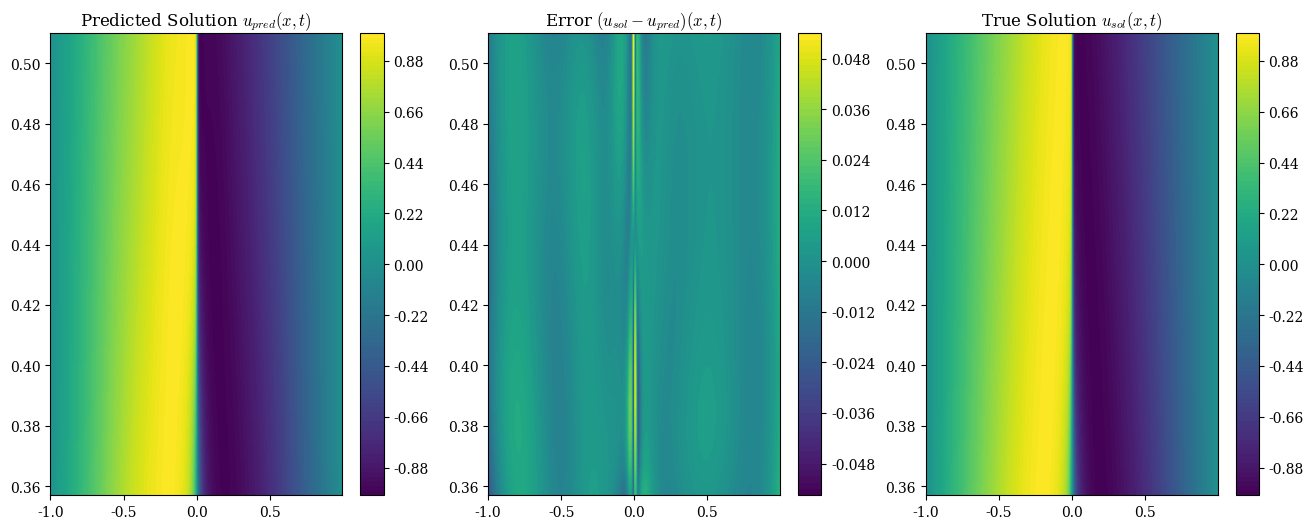

In [141]:
start_index =len(t)-u_plot_all.shape[0]
u_pred_plot = u_plot_all
y_plot = y_plot_all
fig,ax = plt.subplots(1,3,figsize=(16,6))
ax[0].contourf(x,t[start_index:],u_pred_plot, 100, cmap="viridis")
ax[0].set_title(r"Predicted Solution $u_{pred}(x,t)$")
ax[1].contourf(x,t[start_index:],y_plot-u_pred_plot, 100, cmap="viridis")
ax[1].set_title(r"Error $(u_{sol} - u_{pred})(x,t)$")
ax[2].contourf(x,t[start_index:],y_plot, 100, cmap="viridis")
ax[2].set_title(r"True Solution $u_{sol}(x,t)$")
fig.colorbar(ax[0].collections[0], ax=ax[0])
fig.colorbar(ax[1].collections[0], ax=ax[1])
fig.colorbar(ax[2].collections[0], ax=ax[2])
plt.show()

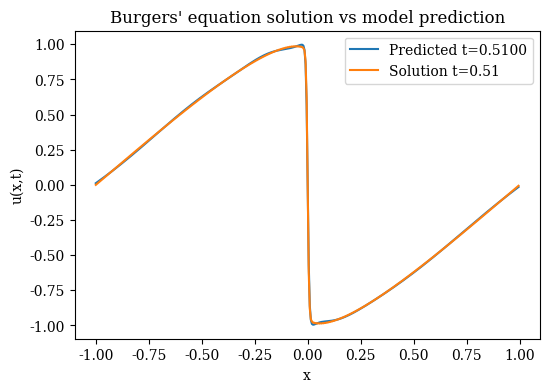

In [142]:
index = -1
fig,ax = plt.subplots(figsize=(6,4))
ax.plot(x,u_pred_plot[index,:], label=f'Predicted t={t[index]:.4f}')
# ax.plot(x,u_pred_tm1_plot[index,:],"--", label=f'Predicted t={t[index-1]:.4f}')
ax.plot(x,y_plot[index,:], label=f'Solution t={t[index]:.2f}')
# ax.plot(x,y_plot[index,:]-u_pred_plot[index,:], label=f'Error t={t[index]:.2f}')
ax.set_title("Burgers' equation solution vs model prediction")
ax.set_xlabel("x")
ax.set_ylabel("u(x,t)")
ax.legend()
plt.show()


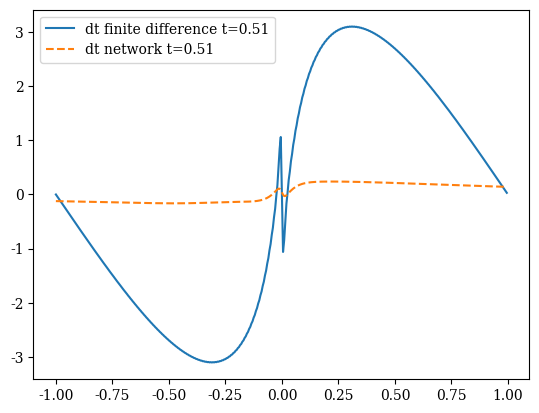

In [135]:
index = -1
# dx_reshaped = dx.reshape(-1,N//x_skips).detach().cpu()
# dt_reshaped = dt.reshape(-1,N//x_skips).detach().cpu()
dt_finit_diff = (y_plot[index,:]-y_plot[index+1,:])/delta_t_synth
# print(dx_reshaped)
# print(dx)
fig,ax = plt.subplots()
# ax.plot(x,dx_plot_all[index,:], label=f'dx')
# ax.plot(x[0:-1], (u_pred_plot[index,1:]-u_pred_plot[index,:-1])/(2/(N//x_skips)),"--",label = "finite difference")
# ax.plot(x,u_pred_plot[index,:], label=f'Predicted t={t[index]:.2f}')
# ax.plot(x,u_pred_plot[index-1,:], label=f'true t={t[index-1]:.2f}')
# ax.plot(x,y_plot[index,:],"--", label=f"true solution at t={t[index]:.2f}")
ax.plot(x,dt_finit_diff, label=f'dt finite difference t={t[-1]:.2f}')
ax.plot(x,dt_plot_all[index,:], "--", label=f'dt network t={t[-1]:.2f}')
ax.legend()

# Why Grad does not work!


x.shape (Nxy,2) torch.Size([100, 2])
output.shape (Nt, Nxy) torch.Size([1, 100])
dx.shape (Nxy, 2) torch.Size([100, 2])
Problem here is there we lose the Nt dimension because grad sums over that dimension 
 grad always returns dimensions similar to inputs thus (Nxy, 2), however we cannot input Nt in the trunk net, that would require two batch dimensions 
We would like to have a dimension (Nt, Nxy, 2) of dx in order to inforce PDE conditions
d2x.shape (Nxy, 2) torch.Size([100, 2])


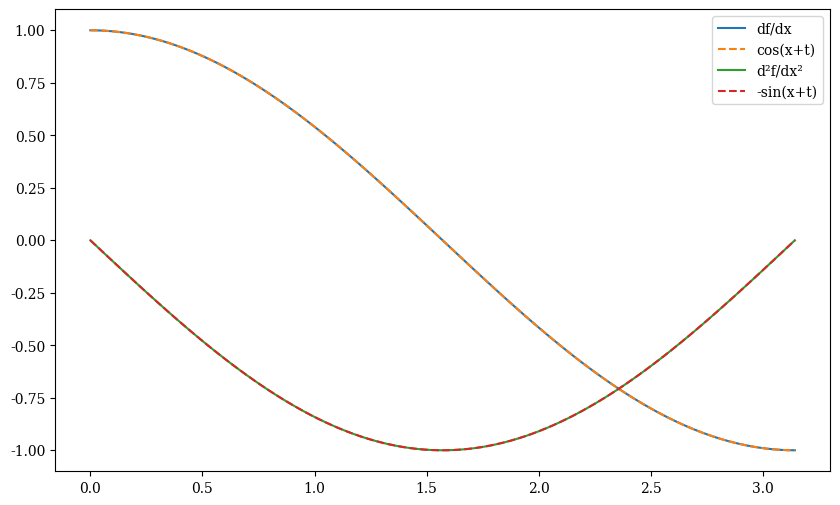

In [30]:
import torch
from torch.autograd.functional import jacobian
import numpy as np
import matplotlib.pyplot as plt

# Test function
def test_func(t, x):
    val = torch.zeros((len(t),x.shape[0]))
    for i  in range(len(t)):
        # print("ti", i)
        val[i] = torch.sin(x[:,0]*0+x[:,1] + t[i])
    return val

t = torch.linspace(0,1,1)
x = torch.linspace(0, np.pi, 100, requires_grad=True)
x = torch.stack((x, x),dim=1)

output = test_func(t, x)
print("x.shape (Nxy,2)", x.shape)
print("output.shape (Nt, Nxy)", output.shape)

dx = grad(outputs=output.sum(dim=-1),
          inputs=x,
          grad_outputs=torch.ones_like(output.sum(dim=-1)),
          create_graph=True,
          retain_graph=True)[0]

print("dx.shape (Nxy, 2)", dx.shape)
print("Problem here is there we lose the Nt dimension because grad sums over that dimension \n " 
    "grad always returns dimensions similar to inputs thus (Nxy, 2), however we cannot input Nt in the trunk net, that would require two batch dimensions \n"
    "We would like to have a dimension (Nt, Nxy, 2) of dx in order to inforce PDE conditions")

dx2 = grad(outputs=dx,
          inputs=x,
          grad_outputs=torch.ones_like(dx),
          create_graph=True,
          retain_graph=True,
          only_inputs=True)[0]
print("d2x.shape (Nxy, 2)", dx2.shape)

fig,ax = plt.subplots(figsize=(10,6))
ax.plot(x[:,0].detach().cpu().numpy(), dx[:,1].detach().cpu().numpy(), label="df/dx")
ax.plot(x[:,0].detach().cpu().numpy(), np.cos(x[:,0].detach().cpu().numpy()+t[0].cpu().numpy()), "--", label="cos(x+t)")
ax.plot(x[:,0].detach().cpu().numpy(), dx2[:,1].detach().cpu().numpy(), label="d²f/dx²")
ax.plot(x[:,0].detach().cpu().numpy(), -np.sin(x[:,0].detach().cpu().numpy()+t[0].cpu().numpy()), "--", label="-sin(x+t)")
ax.legend()
plt.show()

output shape torch.Size([24000])
x shape torch.Size([24000])
t shape torch.Size([24000])
dx.shape (Nxy*Nt, 1) torch.Size([24000])
d2x.shape (Nxy*Nt, 1) torch.Size([24000])


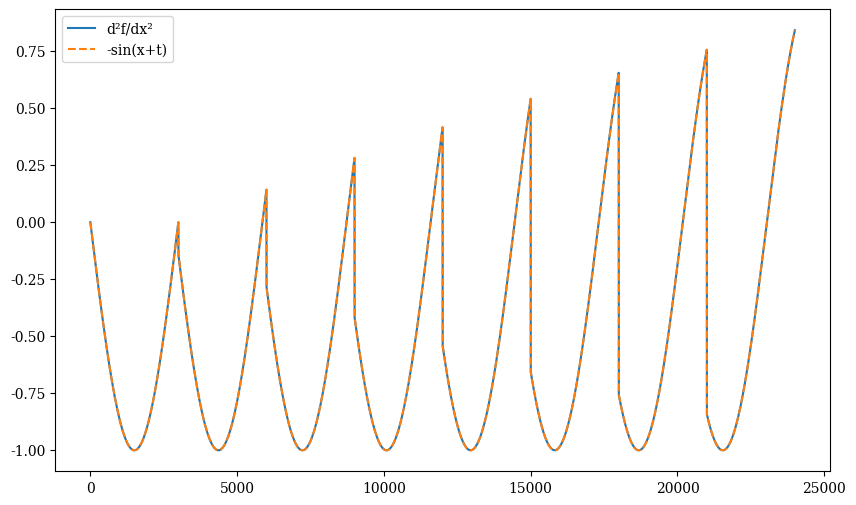

In [36]:
import torch
from torch.autograd.functional import jacobian
import numpy as np
import matplotlib.pyplot as plt

Nt = 8
Nxy = 3000
t_temp = torch.linspace(0,1,Nt)
# x = torch.linspace(0, np.pi, Nxy, requires_grad=True)

def test_func(x,t):
    return torch.sin(x+t)

t = torch.zeros(Nt*Nxy)
x = torch.zeros(Nt*Nxy)
for i in range(Nt):
    t[i*Nxy:(i+1)*Nxy] = t_temp[i]
    x[i*Nxy:(i+1)*Nxy] = torch.linspace(0, np.pi, Nxy)
x.requires_grad_(True)
output = test_func(t,x)
print("output shape", output.shape)
print("x shape", x.shape)
print("t shape", t.shape)

dx = grad(outputs=output,
          inputs=x,
          grad_outputs=torch.ones_like(output),
          create_graph=True,
          retain_graph=True,
          only_inputs=True)[0]
print("dx.shape (Nxy*Nt, 1)", dx.shape)
dx2 = grad(outputs=dx,
          inputs=x,
          grad_outputs=torch.ones_like(dx),
          create_graph=True,
          retain_graph=True,)[0]
print("d2x.shape (Nxy*Nt, 1)", dx2.shape)

x = x.detach().cpu().numpy()
t = t.detach().cpu().numpy()
dx = dx.detach().cpu().numpy()
dx2 = dx2.detach().cpu().numpy()

fig,ax = plt.subplots(figsize=(10,6))
# ax.plot(dx, label="df/dx") 
# ax.plot(np.cos(x+t), "--", label="cos(x+t)")
ax.plot(dx2, label="d²f/dx²")
ax.plot( -np.sin(x+t), "--", label="-sin(x+t)")
ax.legend()
plt.show()


torch.Size([32, 100])
val shape torch.Size([32])
dx torch.Size([32, 100, 2])
torch.Size([32, 100])
val shape torch.Size([32])
jac torch.Size([32])
d2x torch.Size([32, 100, 2])
t: tensor(0.)


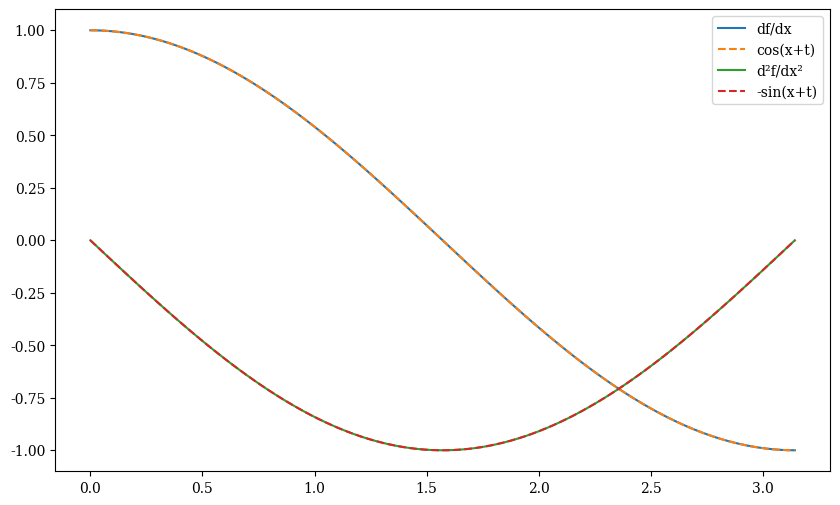

In [35]:
import torch
from torch.autograd.functional import jacobian
import numpy as np
import matplotlib.pyplot as plt

# Test function
def test_func(t, x):
    val = torch.zeros((len(t),x.shape[0]))
    for i  in range(len(t)):
        # print("ti", i)
        val[i] = torch.sin(x[:,0]*0+x[:,1] + t[i])
    return val

t = torch.linspace(0,1,32)
x = torch.linspace(0, np.pi, 100, requires_grad=True)
x = torch.stack((x, x),dim=1)

# First derivative
def f_wrapper(x):
    print(test_func(t, x).shape)
    val = torch.sum(test_func(t, x),dim=1)
    print("val shape", val.shape)
    return torch.sum(test_func(t, x),dim=1)          # shape [100]

def first_derivative(wrapper, coords):
    """
    Computes df/dcoords using torch.autograd.functional.jacobian
    while preserving DeepONet batch dimensions.
    """

    return jacobian(wrapper, coords, create_graph=True)

def second_derivative(wrapper, coords):
    """
    Computes d²f/dcoords² using torch.autograd.functional.hessian
    while preserving DeepONet batch dimensions.
    """
    # jac = first_derivative(wrapper, coords)
    def wrapper_hess(x):
        jac = torch.sum(torch.sum(first_derivative(wrapper, x),dim= 1),dim=1)
        print("jac", jac.shape)
        return jac
    dxdx = jacobian(wrapper_hess, x, create_graph=True)
    return dxdx

dx = first_derivative(f_wrapper, x)
print("dx",dx.shape)

# Second derivative
def f_prime(x):
    j = jacobian(f_wrapper, x, create_graph=True)
    return torch.sum(j,dim= 1)

d2x = second_derivative(f_wrapper, x)
# d2x = jacobian(f_prime, x)         # shape [100, 100]
print("d2x", d2x.shape)

# Plot
index = 0
print("t:", t[index])
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x[:,0].detach().cpu().numpy(), dx[index,:,1].detach().cpu().numpy(), label="df/dx")
ax.plot(x[:,0].detach().cpu().numpy(), np.cos(x[:,0].detach().cpu().numpy()+t[index].cpu().numpy()), "--", label="cos(x+t)")
ax.plot(x[:,0].detach().cpu().numpy(), d2x[index,:,1].detach().cpu().numpy(), label="d²f/dx²")
ax.plot(x[:,0].detach().cpu().numpy(), -np.sin(x[:,0].detach().cpu().numpy()+t[index].cpu().numpy()), "--", label="-sin(x+t)")
ax.legend()
plt.show()

# dx_grad = grad(test_values, x, torch.ones_like(test_values),retain_graph = True, create_graph=True)[0]
# print("dx_grad", dx_grad.shape)